In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import time
import argparse
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torchvision import models
from torch.autograd import Function

In [3]:
manualSeed = 45
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.set_printoptions(linewidth=120)
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

Random Seed:  45


In [4]:
%cd /content/drive/MyDrive/
!unzip '/content/drive/MyDrive/OfficeHomeDataset_10072016.zip' -d '/content/unzipped_files/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/unzipped_files/OfficeHomeDataset_10072016/Clipart/Spoon/00002.jpg  
  inflating: /content/unzipped_files/OfficeHomeDataset_10072016/Clipart/Spoon/00003.jpg  
  inflating: /content/unzipped_files/OfficeHomeDataset_10072016/Clipart/Spoon/00004.jpg  
  inflating: /content/unzipped_files/OfficeHomeDataset_10072016/Clipart/Spoon/00005.jpg  
  inflating: /content/unzipped_files/OfficeHomeDataset_10072016/Clipart/Spoon/00006.jpg  
  inflating: /content/unzipped_files/OfficeHomeDataset_10072016/Clipart/Spoon/00007.jpg  
  inflating: /content/unzipped_files/OfficeHomeDataset_10072016/Clipart/Spoon/00008.jpg  
  inflating: /content/unzipped_files/OfficeHomeDataset_10072016/Clipart/Spoon/00009.jpg  
  inflating: /content/unzipped_files/OfficeHomeDataset_10072016/Clipart/Spoon/00010.jpg  
  inflating: /content/unzipped_files/OfficeHomeDataset_10072016/Clipart/Spoon/00011.jpg  
  inflating: /content/unzipped_files/OfficeHomeDa

In [5]:
dataroot_source = "/content/unzipped_files/OfficeHomeDataset_10072016/Clipart"
dataroot_target = "/content/unzipped_files/OfficeHomeDataset_10072016/Real World"

In [6]:
image_dim = 64

source_dataset = datasets.ImageFolder(root=dataroot_source,
                           transform=transforms.Compose([
                               transforms.Resize(image_dim),
                               transforms.CenterCrop(image_dim),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
target_dataset = datasets.ImageFolder(root=dataroot_target,
                           transform=transforms.Compose([
                               transforms.Resize(image_dim),
                               transforms.CenterCrop(image_dim),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [7]:
batch_size = 128
workers = 2
ngpu = 1

# Creating Dataloader
source_loader = torch.utils.data.DataLoader(source_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
target_loader = torch.utils.data.DataLoader(target_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

In [8]:
len(source_dataset)

4365

In [9]:
len(target_dataset)

4357

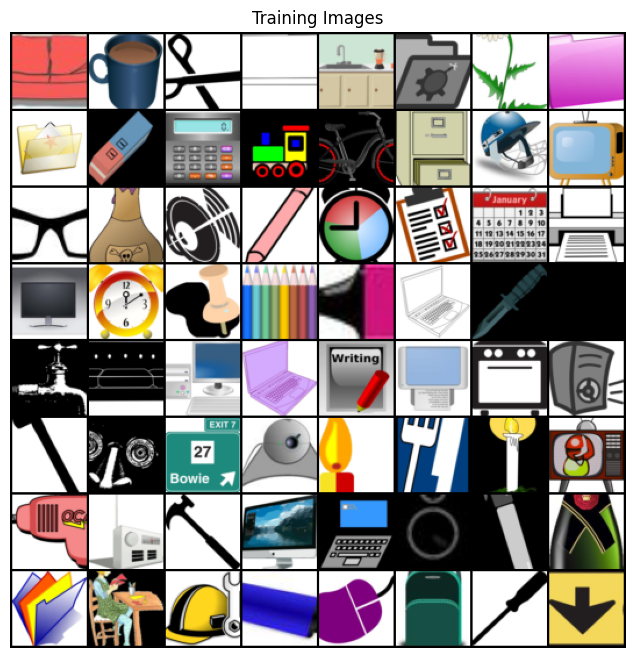

In [10]:
# Plotting Training Images
batch = next(iter(source_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

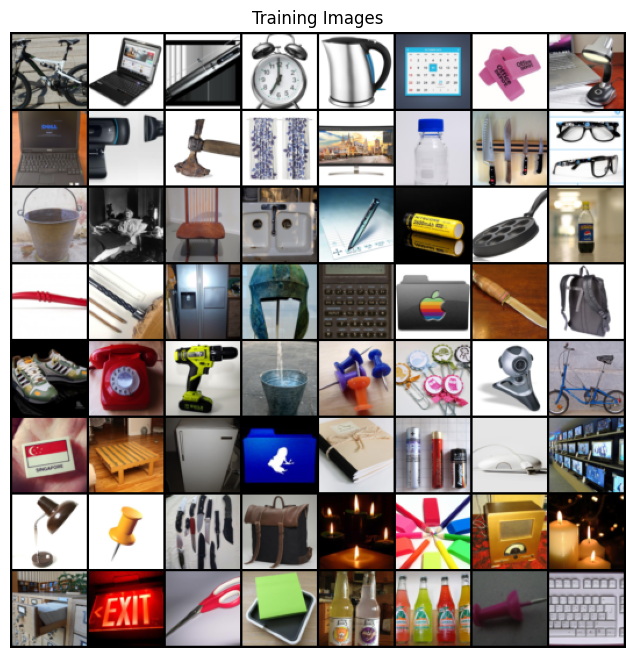

In [11]:
# Plotting Training Images
batch = next(iter(target_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [12]:
for images, labels in target_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

for images, labels in source_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 3, 64, 64])
Image label dimensions: torch.Size([128])
Image batch dimensions: torch.Size([128, 3, 64, 64])
Image label dimensions: torch.Size([128])


In [13]:
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

In [14]:
class Classifier(nn.Module):
    def __init__(self, in_channel = 3, num_classes = 65, domain_classes = 2):
        super(Classifier, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model = torch.nn.Sequential(*(list(self.model.children())[:-1]))

        self.lc = nn.Sequential(
                    nn.Linear(2048, 1024, bias = True),
                    nn.ReLU(),
                    nn.Linear(1024, 512, bias = True),
                    nn.ReLU(),
                    nn.Linear(512, 256, bias = True),
                    nn.ReLU(),
                    nn.Linear(256, num_classes, bias = True),
                    nn.LogSoftmax()
                    )

        self.dc = nn.Sequential(
                    nn.Linear(2048, 256, bias = True),
                    nn.ReLU(),
                    nn.Linear(256, domain_classes, bias = True),
                    nn.LogSoftmax(dim = 1)
                    )

    def forward(self, input, alpha = 1):
        features = self.model(input)
        features = features.view(input.shape[0], -1)

        reversed_input = ReverseLayerF.apply(features, alpha)

        linear_classifier = self.lc(features)
        domain_classifier = self.dc(reversed_input)

        return domain_classifier, linear_classifier

classifier_network = Classifier().to(device)

print(classifier_network)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 104MB/s]


Classifier(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64,

In [15]:
n_epochs = 100

learning_rate = 0.0002
beta1 = 0.5
beta2 = 0.999

optimizer = optim.Adam(classifier_network.parameters(), lr=learning_rate, betas=(beta1, beta2))
loss_class = nn.NLLLoss().to(device)
loss_domain = nn.NLLLoss().to(device)

In [16]:
def get_num_correct_predictions(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

# Source : 0, Target :1
start_time = time.time()

source_loss = []
source_accuracy = []
target_loss = []
target_accuracy = []

for epoch in range(n_epochs):
    classifier_loss = 0
    total_correct = 0
    domain_loss = 0
    total_target_correct = 0

    start_steps = epoch * min(len(source_loader), len(target_loader))
    total_steps = n_epochs * min(len(source_loader), len(target_loader))

    for batch_idx, source_data in enumerate(source_loader):
        classifier_network.train()
        source_image, source_label = source_data

        source_image, source_label = source_image.to(device), source_label.to(device)

        p = float(batch_idx + start_steps) / total_steps
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        optimizer.zero_grad()

        source_domain_pred, class_pred = classifier_network(source_image, alpha)
        class_loss = loss_class(class_pred, source_label)

        domain_source_labels = torch.zeros(source_label.shape[0]).type(torch.LongTensor).to(device)

        source_domain_loss = loss_domain(source_domain_pred, domain_source_labels)

        total_loss = class_loss + source_domain_loss #+ target_domain_loss

        total_loss.backward()
        optimizer.step()

        classifier_network.eval()

        classifier_loss += total_loss.item()
        domain_loss += source_domain_loss.item() #+ target_domain_loss.item()
        total_correct += get_num_correct_predictions(class_pred, source_label)

    for j in range(1):
        for batch_idx, target_data in enumerate(target_loader, 0):
            target_image, target_label = target_data
            target_image, target_label = target_image.to(device), target_label.to(device)

            p = float(batch_idx + start_steps) / total_steps
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            optimizer.zero_grad()

            target_domain_pred, target_class_pred = classifier_network(target_image, alpha)

            domain_target_labels = torch.ones(target_label.shape[0]).type(torch.LongTensor).to(device)

            target_domain_loss = loss_domain(target_domain_pred, domain_target_labels)

            total_loss = target_domain_loss

            domain_loss += target_domain_loss.item()
            total_target_correct += get_num_correct_predictions(target_class_pred, target_label)

            total_loss.backward()
            optimizer.step()


    source_loss.append(classifier_loss)
    source_accuracy.append(total_correct / len(source_dataset) * 100)
    target_loss.append(domain_loss)
    target_accuracy.append(total_target_correct / len(target_dataset) * 100)



    print(
            "[Epoch %d/%d] [Source_loss: %f] [Discriminator_loss: %f] [Source_Accuracy: %f] [Target_Accuracy: %f]"
            % (epoch, n_epochs, classifier_loss, domain_loss, total_correct / len(source_dataset) * 100, total_target_correct / (len(target_dataset)) * 100
            ))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 0/100] [Source_loss: 140.401179] [Discriminator_loss: 22.864566] [Source_Accuracy: 6.300115] [Target_Accuracy: 3.695203]
Time elapsed: 1.78 min
[Epoch 1/100] [Source_loss: 142.933392] [Discriminator_loss: 60482425816919436483887104.000000] [Source_Accuracy: 21.168385] [Target_Accuracy: 1.813174]
Time elapsed: 3.49 min
[Epoch 2/100] [Source_loss: 172.471710] [Discriminator_loss: 48.781982] [Source_Accuracy: 2.268041] [Target_Accuracy: 1.514804]
Time elapsed: 5.17 min
[Epoch 3/100] [Source_loss: 170.063223] [Discriminator_loss: 48.788541] [Source_Accuracy: 2.245132] [Target_Accuracy: 1.491852]
Time elapsed: 6.81 min
[Epoch 4/100] [Source_loss: 169.767110] [Discriminator_loss: 48.963291] [Source_Accuracy: 2.153494] [Target_Accuracy: 1.904980]
Time elapsed: 8.40 min
[Epoch 5/100] [Source_loss: 169.646832] [Discriminator_loss: 48.654520] [Source_Accuracy: 2.176403] [Target_Accuracy: 1.491852]
Time elapsed: 10.10 min
[Epoch 6/100] [Source_loss: 170.076556] [Discriminator_loss: 49.1216

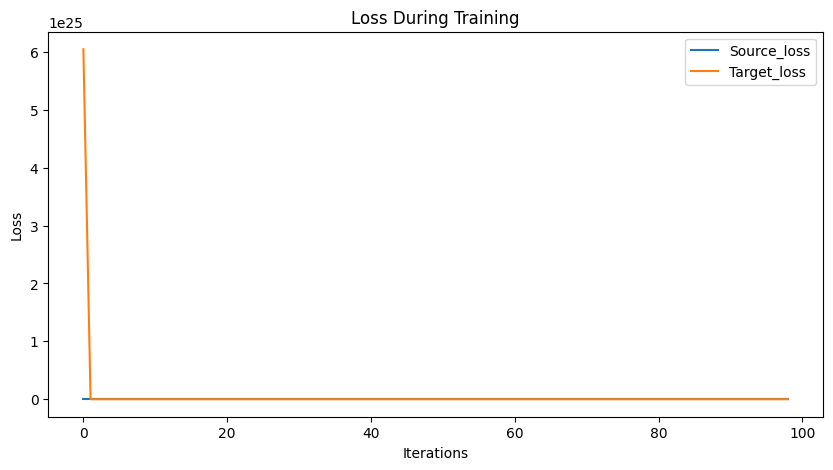

In [17]:
# Saving Source and Target Loss during training
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(source_loss[1:],label="Source_loss")
plt.plot(target_loss[1:],label="Target_loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

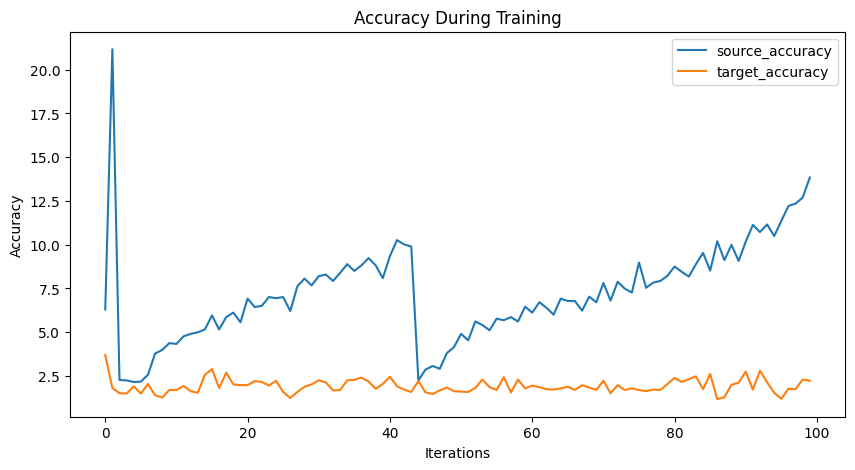

In [18]:
# Saving Source and Target Accuracy during training
plt.figure(figsize=(10,5))
plt.title("Accuracy During Training")
plt.plot(source_accuracy,label="source_accuracy")
plt.plot(target_accuracy,label="target_accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [19]:
class Feature_Extractor(nn.Module):
    def __init__(self, in_channel = 3, num_classes = 10, domain_classes = 2):
        super(Feature_Extractor, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model = torch.nn.Sequential(*(list(self.model.children())[:-1]))

    def forward(self, input):
        features = self.model(input)
        features = features.view(input.shape[0], -1)

        return features


class Classifier(nn.Module):
    def __init__(self, num_classes = 65):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
                        nn.Linear(2048, 1024, bias = True),
                        nn.ReLU(),
                        nn.Linear(1024, 512, bias = True),
                        nn.ReLU(),
                        nn.Linear(512, 256, bias = True),
                        nn.ReLU(),
                        nn.Linear(256, num_classes, bias = True),
                        nn.LogSoftmax()
                    )

    def forward(self, features):
        output = self.model(features)

        return output

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
                        nn.Linear(2048, 1024, bias = True),
                        nn.ReLU(),
                        nn.Linear(1024, 512, bias = True),
                        nn.ReLU(),
                        nn.Linear(512, 256, bias = True),
                        nn.ReLU(),
                        nn.Linear(256, 1, bias = True),
                    )

    def forward(self, features):
        output = self.model(features)

        return output

features_network = Feature_Extractor().to(device)
classifier_network = Classifier().to(device)
discriminator_network = Discriminator().to(device)

# Number of Epochs
n_epochs = 100

# Adam Optimizer Parameters for Generator and Discriminator
learning_rate = 0.002
beta1 = 0.5
beta2 = 0.999

loss_class = nn.NLLLoss().to(device)
optimizer = optim.Adam(list(features_network.parameters()) + list(classifier_network.parameters()), lr=learning_rate, betas=(beta1, beta2))

In [20]:
def get_num_correct_predictions(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

# Source : 0, Target :1
start_time = time.time()

source_loss = []
source_accuracy = []

for epoch in range(n_epochs):
    classifier_loss = 0
    total_correct = 0

    for batch_idx, source_data in enumerate(source_loader):
        classifier_network.train()
        features_network.train()

        source_image, source_label = source_data
        source_image, source_label = source_image.to(device), source_label.to(device)

        optimizer.zero_grad()

        source_features = features_network(source_image)
        class_pred = classifier_network(source_features)

        class_loss = loss_class(class_pred, source_label)

        total_loss = class_loss

        total_loss.backward()
        optimizer.step()

        classifier_loss += total_loss.item()
        total_correct += get_num_correct_predictions(class_pred, source_label)


    print(
            "[Epoch %d/%d] [Source_loss: %f] [Source_Accuracy: %f] "
            % (epoch, n_epochs, classifier_loss, total_correct / len(source_dataset) * 100,
            ))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

[Epoch 0/100] [Source_loss: 144.625096] [Source_Accuracy: 3.276060] 
Time elapsed: 0.20 min
[Epoch 1/100] [Source_loss: 142.451383] [Source_Accuracy: 3.207331] 
Time elapsed: 0.43 min
[Epoch 2/100] [Source_loss: 138.449142] [Source_Accuracy: 4.123711] 
Time elapsed: 0.66 min
[Epoch 3/100] [Source_loss: 134.938181] [Source_Accuracy: 4.696449] 
Time elapsed: 0.86 min
[Epoch 4/100] [Source_loss: 134.110902] [Source_Accuracy: 4.925544] 
Time elapsed: 1.07 min
[Epoch 5/100] [Source_loss: 130.489733] [Source_Accuracy: 6.185567] 
Time elapsed: 1.29 min
[Epoch 6/100] [Source_loss: 127.104095] [Source_Accuracy: 7.697595] 
Time elapsed: 1.52 min
[Epoch 7/100] [Source_loss: 125.621957] [Source_Accuracy: 8.797251] 
Time elapsed: 1.71 min
[Epoch 8/100] [Source_loss: 122.610906] [Source_Accuracy: 9.896907] 
Time elapsed: 1.93 min
[Epoch 9/100] [Source_loss: 119.396793] [Source_Accuracy: 10.194731] 
Time elapsed: 2.16 min
[Epoch 10/100] [Source_loss: 118.117445] [Source_Accuracy: 11.042383] 
Time ela

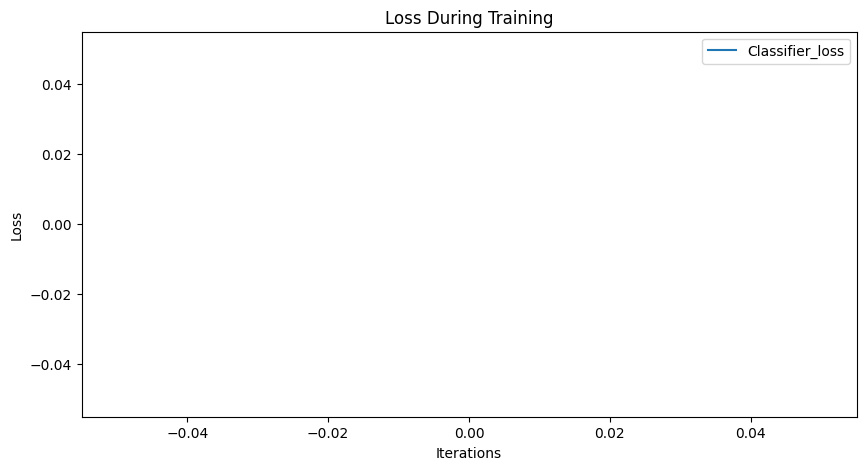

In [21]:
# Saving Source and Target Loss during training
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(source_loss,label="Classifier_loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
torch.save(features_network.state_dict(), "./features_network" + ".pth")

In [23]:
model = Feature_Extractor().to(device)
model.load_state_dict(torch.load("./features_network" + ".pth"))

# Number of Epochs
n_epochs = 100

# Adam Optimizer Parameters for Generator and Discriminator
learning_rate = 0.0002
beta1 = 0.5
beta2 = 0.999

loss_domain = nn.NLLLoss().to(device)
optimizer = optim.RMSprop(list(model.parameters()) + list(discriminator_network.parameters()), lr=learning_rate)

In [27]:
# Source : 0, Target :1
start_time = time.time()

domain_loss = []

for epoch in range(n_epochs):
    loss = 0
    source_iter = iter(source_loader)
    target_iter = iter(target_loader)

    for i in range(min(len(source_loader), len(target_loader))):
        discriminator_network.train()
        features_network.eval()
        model.train()

        source_image, source_label = next(source_iter)
        source_image, source_label = source_image.to(device), source_label.to(device)

        target_image, target_label = next(target_iter)
        target_image, target_label = target_image.to(device), target_label.to(device)

        source_features = features_network(source_image)
        source_class_domain = discriminator_network(source_features)

        target_features = model(target_image)
        target_class_domain = discriminator_network(target_features)

        optimizer.zero_grad()
#         print(torch.mean(source_class_domain),  torch.mean(target_class_domain))
        total_loss = -torch.mean(source_class_domain) + torch.mean(target_class_domain)

        total_loss.backward()
        optimizer.step()

        # clip weights of discriminator
        for p in discriminator_network.parameters():
            p.data.clamp_(-0.001, 0.001)

        loss += total_loss.item()

    domain_loss.append(loss)
    print(
            "[Epoch %d/%d] [Source_loss: %f]"
            % (epoch, n_epochs, loss
            ))



    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

[Epoch 0/100] [Source_loss: -0.088573]
Time elapsed: 1.85 min
[Epoch 1/100] [Source_loss: -0.086680]
Time elapsed: 3.54 min
[Epoch 2/100] [Source_loss: -0.087251]
Time elapsed: 5.19 min
[Epoch 3/100] [Source_loss: -0.088251]
Time elapsed: 6.87 min
[Epoch 4/100] [Source_loss: -0.089529]
Time elapsed: 8.55 min
[Epoch 5/100] [Source_loss: -0.089828]
Time elapsed: 10.16 min
[Epoch 6/100] [Source_loss: -0.089830]
Time elapsed: 11.83 min
[Epoch 7/100] [Source_loss: -0.090643]
Time elapsed: 13.44 min
[Epoch 8/100] [Source_loss: -0.095560]
Time elapsed: 15.07 min
[Epoch 9/100] [Source_loss: -0.094882]
Time elapsed: 16.71 min
[Epoch 10/100] [Source_loss: -0.091445]
Time elapsed: 18.31 min
[Epoch 11/100] [Source_loss: -0.091300]
Time elapsed: 19.96 min
[Epoch 12/100] [Source_loss: -0.091789]
Time elapsed: 21.55 min
[Epoch 13/100] [Source_loss: -0.092497]
Time elapsed: 23.19 min
[Epoch 14/100] [Source_loss: -0.092622]
Time elapsed: 24.82 min
[Epoch 15/100] [Source_loss: -0.092408]
Time elapsed: 2

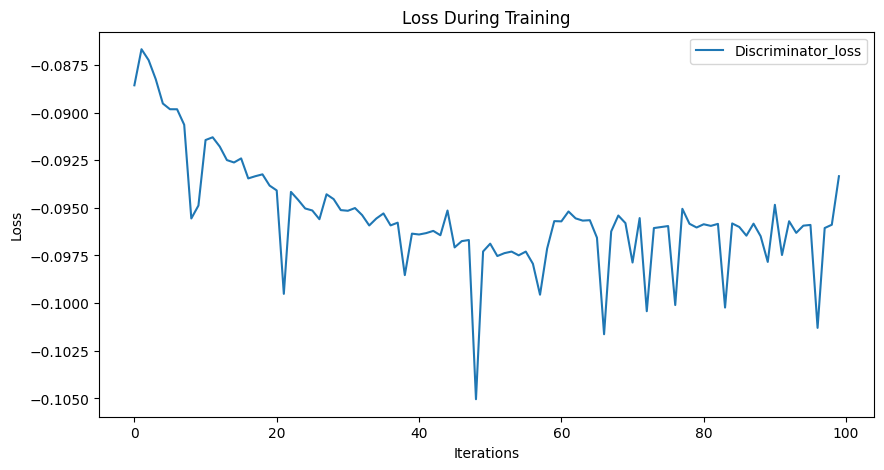

In [28]:
# Saving Source and Target Loss during training
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(domain_loss,label="Discriminator_loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [29]:
total_correct = 0
for batch_idx, source_data in enumerate(target_loader):
        classifier_network.eval()
        model.eval()

        source_image, source_label = source_data
        source_image, source_label = source_image.to(device), source_label.to(device)

        source_features = model(source_image)
        class_pred = classifier_network(source_features)

        total_correct += get_num_correct_predictions(class_pred, source_label)

print(total_correct / len(target_dataset) * 100)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


1.7902226302501723


In [1]:
total_correct

NameError: ignored